In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW,SGD 

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


from transformers import AutoTokenizer

In [2]:
import dependency_model as dep
import utils_generic as utils

# Auxiliar

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Procesado datos train: ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai_complete.json','r') as f:
    data = json.load(f)

In [6]:
# Utilizo convai2 para crear el vocabulario porque es el conjunto más grande de los usados
vocab = dep.Vocabulary(data,'relative')
convai_tokenized = dep.tokenize_dataset_with_dependencies(data,tokenizer,['to','as','about'],vocab)

In [7]:
convai_size = len(convai_tokenized)

In [8]:
val_size = round(convai_size *0.1)
train_size = convai_size - val_size

# Procesado datos evaluación: md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = dep.tokenize_dataset_with_dependencies(md_data,tokenizer,['to','as','about'],vocab)

# Creación dataloaders

In [11]:
convai_dataset = dep.CustomDataset(convai_tokenized,['to','as','about'],eval=False)
md_dataset = dep.CustomDataset(md_tokenized,['to','as','about'],eval=True)



In [12]:
convai_train, convai_val = torch.utils.data.random_split(convai_dataset,[train_size,val_size])

In [13]:
dl_train =DataLoader(convai_train,batch_size=128,shuffle=True,collate_fn=dep.collate_fn)
dl_val =DataLoader(convai_val,batch_size=128,shuffle=False,collate_fn=dep.collate_fn)
dl_eval =DataLoader(md_dataset,batch_size=32,shuffle=False,collate_fn=dep.collate_fn)

# Modelo

In [14]:
# Parámetros
hidden_dim = 128
embedding_dim = 100
model_name = "distilbert-base-uncased"
num_labels = 3
tasks = ['to','as','about']

In [15]:
model = dep.MultiWithDependencies(model_name, num_labels,tasks,vocab,embedding_dim,lstm_hidden_dim=hidden_dim).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# model.load_state_dict(torch.load('distilbert_100_SGD_DV'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/103400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.15930208800148 	 Validation loss: 2.06981059600567 
  0%|          | 517/103400 [01:43<5:48:37,  4.92it/s]
Epoch 2 	 Training loss: 2.0556391057931247 	 Validation loss: 2.022285058580596 
  1%|          | 1034/103400 [03:29<4:35:50,  6.19it/s]
Epoch 3 	 Training loss: 2.014697462723841 	 Validation loss: 1.9884170293807983 
  2%|▏         | 1551/103400 [05:17<5:48:53,  4.87it/s]
Epoch 4 	 Training loss: 1.9949828434728332 	 Validation loss: 1.9830414138991257 
  2%|▏         | 2068/103400 [07:04<5:52:56,  4.79it/s]
Epoch 5 	 Training loss: 1.9863104391374717 	 Validation loss: 1.972491467821187 
  2%|▎         | 2585/103400 [08:50<4:33:19,  6.15it/s]
Epoch 6 	 Training loss: 1.9805860217350826 	 Validation loss: 1.9623643447612893 
  3%|▎         | 3102/103400 [10:35<5:42:29,  4.88it/s]
Epoch 7 	 Training loss: 1.980252067171167 	 Validation loss: 1.97388022932513 
  4%|▎         | 3619/103400 [12:19<5:49:48,  4.75it/s]
Epoch 8 	 Training loss: 1.97777955813

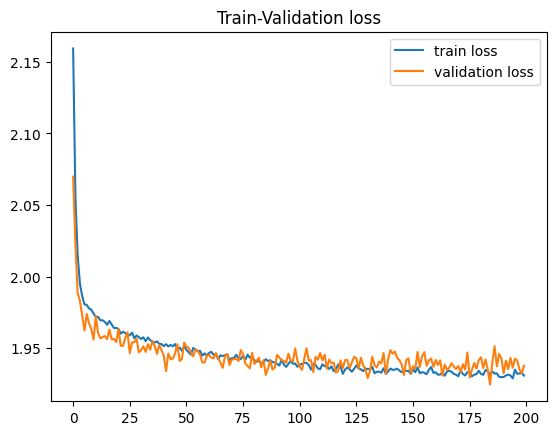

In [17]:
model = dep.MultiWithDependencies(model_name, num_labels,tasks,vocab,embedding_dim,lstm_hidden_dim=hidden_dim).to(device)




learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 200

train_loss, val_loss = dep.train_functionV(model,num_epochs,dl_train,optimizer=optimizer,dl_val=dl_val)
torch.save(model.state_dict(),'distilbert_200_SGD_DV')
utils.plot_losses_val(train_loss,val_loss)


In [20]:
metrics = ["accuracy","f1","precision","recall"]
for metric in metrics:
    print(metric)
    print(dep.eval_function_multi(model,dl_eval,tasks,metric))
    print('\n')

accuracy
{'to': {'accuracy': 0.7196969696969697}, 'as': {'accuracy': 0.7235984354628422}, 'about': {'accuracy': 0.8392857142857143}}


f1
{'to': {'f1': 0.7305825242718447}, 'as': {'f1': 0.7260981912144703}, 'about': {'f1': 0.8350785340314136}}


precision
{'to': {'precision': 0.7288135593220338}, 'as': {'precision': 0.7433862433862434}, 'about': {'precision': 0.8394736842105263}}


recall
{'to': {'recall': 0.732360097323601}, 'as': {'recall': 0.7095959595959596}, 'about': {'recall': 0.8307291666666666}}


